# Review
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

In [1]:
!pip install -q --user --upgrade pandas sklearn

In [2]:
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, \
                            f1_score, recall_score, precision_score, matthews_corrcoef

# User behaviour classification
#### \- comissioned by: Mobile carrier "Megaline"
***

Mobile carrier Megaline found out that many of their users use legacy plans.  
They wish to recommend them to move to their newer plans: Smart or Ultra.  
In order to develop such a system,  
we will create classification models which will process the characteristics of users who already use the plans,  
and will decide which plan fits the legacy users based this.

Our target accuracy for this exercise is  at least 0.75.

<br>

## Table of Contents
- [Load dataset](#Load-dataset)
- [Split dataset](#Split-dataset)
- [Classification models](#Classification-models)
    - [Logistic Regression Classifier](#Logistic-Regression-Classifier)
    - [Decision Tree Classifier](#Decision-Tree-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Models comparison](#Models-comparison)  
- [Sanity check](#Sanity-check)
- [Conclusions](#Conclusions)

<br>

## Load dataset
***
[back](#Table-of-Contents)

Each entry contains monthly behaviour of a user.  
Columns' description:
- сalls — number of calls
- minutes — total call duration in minutes
- messages — number of text messages
- mb_used — Internet traffic used in MB
- is_ultra — plan for the current month (Ultra - 1, Smart - 0)

In [3]:
def find_file(filename):
    """Returns file path under /datasets directory, if exists, otherwise uses local dir"""
    
    filepath = f'/datasets/{filename}'
    if not os.path.isfile(filepath):
        filepath = filename
        
    return filepath

# find_file('users_behavior.csv')

In [4]:
filename = find_file('users_behavior.csv')

In [5]:
!wc "$filename"
!head -n3 "$filename"

    3215    3215  134358 users_behavior.csv
calls,minutes,messages,mb_used,is_ultra
40.0,311.8999999999999,83.0,19915.42,0
85.0,516.75,56.0,22696.96,0


In [6]:
df = pd.read_csv(filename)

In [7]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [8]:
df.shape

(3214, 5)

We have 3214 observations, and 5 features.  
Out of all features, 'is_ultra' is our target feature.

In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [10]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


There are no illogical values (negative numbers, extreme outliers).

In [11]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

There are no missing values.

In [12]:
df[df.duplicated(keep=False)]

,calls,minutes,messages,mb_used,is_ultra


In [13]:
df.duplicated().sum()

0

There are no duplicated entries.

<div class="alert alert-success">
<b>Reviewer's comment</b>
  
Alright, the data was loaded and inspected!
  
</div>

<br>

## Split dataset
***
[back](#Table-of-Contents)

Data should be split into Features and Target feature (is_ultra), for the consumption of ML models.  
Also, we should split it into 3 different sets:
- Training (60%)
- Validation (20%)
- Testing (20%)

We split the data in this way in order to avoid leaking knowledge about the test set into the model settings,  
while in the process of tweaking the model's hyperparameters.  
\- https://scikit-learn.org/stable/modules/cross_validation.html

In [14]:
def split_dataset(df, *args, random_state=42):
    """Splits a dataset to portions. (train/valid/test)"""
    
    assert sum(args) <= 1, "Arguments' sum must be <= 1"
    
    cumsum = (np.cumsum(args) * df.shape[0]).astype('int')
    # print(cumsum) # defines on which index to split
    
    return [n for n in np.split(df.sample(frac=1, random_state=random_state), cumsum) if len(n) != 0]

In [15]:
train_df, valid_df, test_df = split_dataset(df, .6, .2, .2)

In [16]:
train_X = train_df.drop('is_ultra', axis=1)
train_y = train_df['is_ultra']

In [17]:
valid_X = valid_df.drop('is_ultra', axis=1)
valid_y = valid_df['is_ultra']

In [18]:
test_X = test_df.drop('is_ultra', axis=1)
test_y = test_df['is_ultra']

In [19]:
print(f'Training:\tshape={train_X.shape}\tproportion={round(train_df.shape[0]/df.shape[0], 2)}', 
      f'Validation:\tshape={valid_X.shape}\tproportion={round(valid_df.shape[0]/df.shape[0], 2)}', 
      f'Testing:\tshape={test_X.shape}\tproportion={round(test_df.shape[0]/df.shape[0], 2)}', sep='\n')

Training:	shape=(1928, 4)	proportion=0.6
Validation:	shape=(643, 4)	proportion=0.2
Testing:	shape=(643, 4)	proportion=0.2


<div class="alert alert-success">
<b>Reviewer's comment</b>
  
The data was split into train, validation and set. The proportions of the sets are reasonable.
  
</div>

<br>

## Classification models
***
[back](#Table-of-Contents)

This task is of classification type ('is_ultra' either 1 or 0), will train and compare following models:
- [Logistic Regression Classifier](#Logistic-Regression-Classifier)
- [Decision Tree Classifier](#Decision-Tree-Classifier)
- [Random Forest Classifier](#Random-Forest-Classifier)

[Models comparison](#Models-comparison)  
Accuracy (correct answers / all answers) is an appropriate success metric for this classification task.

We will be using 'GridSearchCV' to automatically search for the best possible combination of hyperparameters of each model.  
This warrants a different data split, since it does the Cross-Validation internally on the training data.

<div class="alert alert-success">
<b>Reviewer's comment</b>
  
Yeah, sure, if we use cross-validation, the validation set is not needed!
  
</div>

In [20]:
def generate_model_report(model, params, data, **kwargs):
    """
    Runs GridSearchCV and reports CV and Test accuracy.
    
    Returns GridSearchCV object, scores datafreame, CV best score, Test score, and run time in milliseconds.
    """
    
    assert data != None and len(data) == 4, ''
    X_train, y_train, X_test, y_test = data
    
    kwargs['estimator'] = model
    kwargs['param_grid'] = params
    
    start_time = timer()
    
    gscv = GridSearchCV(**kwargs)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        display(gscv.fit(X_train, y_train))
        
    scores = pd.DataFrame(gscv.cv_results_)
    test_score = gscv.best_estimator_.score(X_test, y_test)
    
    end_time = timer()
    run_time = (end_time - start_time) * 1000
    
    # display(scores.nlargest(3, 'mean_test_score'))
    display(Markdown(f'_Best estimator_: {gscv.best_estimator_}  \n\
                        _CV accuracy_: {gscv.best_score_}  \n\
                        _Test accuracy_: {test_score}'))
    
    return gscv, scores, gscv.best_score_, test_score, run_time

In [21]:
# # tests generate_model_report function

# %%time
# a, b, c, d, e = generate_model_report(
#     lr_model, 
#     {
#         'tol': [1],
#     },
#     [X_train, y_train, X_test, y_test],
#     cv=5, scoring='accuracy', error_score=0,
#     n_jobs=-1, verbose=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('is_ultra', axis=1),
    df['is_ultra'],
    test_size=.2,
    random_state=12345)

In [23]:
print(f'Training:\tshape={X_train.shape}\tproportion={round(X_train.shape[0]/df.shape[0], 2)}',
      f'Testing:\tshape={X_test.shape}\tproportion={round(X_test.shape[0]/df.shape[0], 2)}', sep='\n')

Training:	shape=(2571, 4)	proportion=0.8
Testing:	shape=(643, 4)	proportion=0.2


### Logistic Regression Classifier
[up](#Classification-models)

Model's documentation will help us to ascertain the possible range of values for the hyperparameters.  
Setting 'random_state' to a constant value, so experiment results are reproducible.

In [24]:
# LogisticRegression?

In [25]:
lr_model = LogisticRegression(random_state=12345)

In [26]:
lr_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12345,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [27]:
%%time
lr_gscv, lr_scores, lr_cv_accuracy, lr_test_accuracy, lr_run_time = generate_model_report(
    lr_model, 
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'tol': [1, 0.1, 0.01, 0.001],
        'C': [0.1, 0.3, 0.5, 0.7, 1],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [10, 50, 100, 300, 1000],
    },
    [X_train, y_train, X_test, y_test],
    cv=5, scoring='accuracy', error_score=0,
    n_jobs=-1, verbose=1)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


GridSearchCV(cv=5, error_score=0,
             estimator=LogisticRegression(random_state=12345), n_jobs=-1,
             param_grid={'C': [0.1, 0.3, 0.5, 0.7, 1],
                         'max_iter': [10, 50, 100, 300, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=1)

_Best estimator_: LogisticRegression(C=0.1, max_iter=50, penalty='none', random_state=12345,
                   solver='newton-cg', tol=0.1)  
                        _CV accuracy_: 0.7452366740961807  
                        _Test accuracy_: 0.7573872472783826

CPU times: user 5.28 s, sys: 315 ms, total: 5.59 s
Wall time: 28.1 s


### Decision Tree Classifier
[up](#Classification-models)

In [28]:
# DecisionTreeClassifier?

In [29]:
dt_model = DecisionTreeClassifier(random_state=12345)

In [30]:
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}

In [31]:
%%time
dt_gscv, dt_scores, dt_cv_accuracy, dt_test_accuracy, dt_run_time = generate_model_report(
    dt_model, 
    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [1, 5, 10, 15], # range(20), # range(0, 51, 2),
        'min_samples_leaf': [1, 3, 5], # range(1,6),
        'min_impurity_decrease': [.0, .01, .001],
        # 'ccp_alpha': [.0, .01, .03, .05, .1, .5, .7],
    },
    [X_train, y_train, X_test, y_test],
    cv=5, scoring='accuracy', error_score=0,
    n_jobs=-1, verbose=1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, error_score=0,
             estimator=DecisionTreeClassifier(random_state=12345), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 5, 10, 15],
                         'min_impurity_decrease': [0.0, 0.01, 0.001],
                         'min_samples_leaf': [1, 3, 5],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

_Best estimator_: DecisionTreeClassifier(criterion='entropy', max_depth=15,
                       min_impurity_decrease=0.001, random_state=12345,
                       splitter='random')  
                        _CV accuracy_: 0.8028008008764308  
                        _Test accuracy_: 0.7822706065318819

CPU times: user 922 ms, sys: 77.8 ms, total: 1e+03 ms
Wall time: 1 s


### Random Forest Classifier
[up](#Classification-models)

In [32]:
# RandomForestClassifier?

In [33]:
rf_model = RandomForestClassifier(random_state=12345)

In [34]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [35]:
%%time
rf_gscv, rf_scores, rf_cv_accuracy, rf_test_accuracy, rf_run_time = generate_model_report(
    rf_model, 
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [1, 5, 10, 15], # range(20),
        'min_samples_leaf': [1, 3, 5], # range(1,6),
        'min_impurity_decrease': [.0, .01, .001],
    },
    [X_train, y_train, X_test, y_test],
    cv=5, scoring='accuracy', error_score=0,
    n_jobs=-1, verbose=1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, error_score=0,
             estimator=RandomForestClassifier(random_state=12345), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 5, 10, 15],
                         'min_impurity_decrease': [0.0, 0.01, 0.001],
                         'min_samples_leaf': [1, 3, 5]},
             scoring='accuracy', verbose=1)

_Best estimator_: RandomForestClassifier(criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.001, min_samples_leaf=3,
                       random_state=12345)  
                        _CV accuracy_: 0.8203067507838767  
                        _Test accuracy_: 0.7993779160186625

CPU times: user 1.16 s, sys: 77.6 ms, total: 1.24 s
Wall time: 15.4 s


### Models comparison
[up](#Classification-models)

In [36]:
test_scores = pd.DataFrame(
    [
        [lr_cv_accuracy, lr_test_accuracy, lr_run_time / 1_000],
        [dt_cv_accuracy, dt_test_accuracy, dt_run_time / 1_000],
        [rf_cv_accuracy, rf_test_accuracy, rf_run_time / 1_000],
    ],
    columns=['CV (accuracy)', 'Test (accuracy)', 'Time (s)'], 
    index=['Logistic Regression', 'Decision Tree', 'Random Forest'])

In [37]:
test_scores.sort_values(by='Test (accuracy)', ascending=False)

,CV (accuracy),Test (accuracy),Time (s)
Random Forest,0.820307,0.799378,15.361006
Decision Tree,0.802801,0.782271,1.003154
Logistic Regression,0.745237,0.757387,28.137575


Random Forest classifier had the best test accuracy on the given dataset,  
but Decision Tree classifier had the best time (<1s).  
Logistic Regression performed worse on all metrics.

Which is better depends on the business requirements.  
If we need the absolute best accuracy we would have to improve the test accuracy since Random Forest's 0.79 is quite low,  
and if we need the fastest algorithm we would use the Decision Tree classifier in this case.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
  
Very nice, you tried a couple of different models and tuned their hyperparameters using k-fold cross-validation. It's a good idea to also measure the runtime of the models, but it seems that your comparison is not fair, because if we calculate the number of hyperparameter values tried for each model, it turns out that logistic regression was tried with ~2000 different hyperparameter tuples, while other models were tried with just about ~100 different hyperparameter tuples, an order of magnitude lower. As it is possible to vary this number arbitrarily, I think a better measure would be the trainining time and prediction time of an already tuned model. If you check that, you'll find out that logistic regression is actually the fastest.
  
</div>

<br>

## Sanity check
***
[back](#Table-of-Contents)

We would like to check that our model performs better than chance.

In [38]:
def score_metrics(y_true, y_pred):
    """Returns a map of different metrics."""
    
    cm = confusion_matrix(y_true, y_pred)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        return {'accuracy': accuracy_score(y_true, y_pred),
                'confusion_matrix': {'tn': cm[0, 0], 'fp': cm[0, 1],
                                     'fn': cm[1, 0], 'tp': cm[1, 1]},
                'recall': recall_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred),
                'f1_score': f1_score(y_true, y_pred),
                'matthews_corrcoef': matthews_corrcoef(y_true, y_pred)}

In [39]:
def metrics_report(model, test_data):
    """
    Creates a report of different metrics.
    Also plots a confusion matrix.
    """
    
    X_test, y_test = test_data
    y_pred = model.predict(X_test)
    display(score_metrics(y_test, y_pred))
    plt.show(plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test, cmap='Blues', 
                                   normalize='all', values_format='.2g'))

In [40]:
y_train.apply(
    ['value_counts', lambda x:x.value_counts(normalize=True).round(2)]).set_axis(['count', 'ratio'], axis=1)

,count,ratio
0,1782,0.69
1,789,0.31


In [41]:
y_test.apply(
    ['value_counts', lambda x:x.value_counts(normalize=True).round(2)]).set_axis(['count', 'ratio'], axis=1)

,count,ratio
0,447,0.7
1,196,0.3


Our target feature shows class imbalance (70% of the values are 0, 30% are 1).  
In order to be certain that our selected model performs better than a constant model,  
we will use a dummy model as a baseline for accuracy, and compare that with the accuracy of our best performing models.

__Baseline (dummy model)__

{'accuracy': 0.6951788491446346,
 'confusion_matrix': {'tn': 447, 'fp': 0, 'fn': 196, 'tp': 0},
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0,
 'matthews_corrcoef': 0.0}

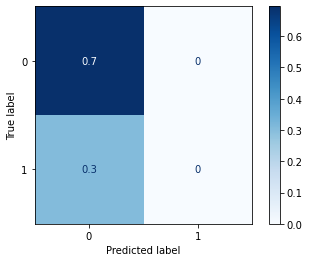

In [42]:
display(Markdown('__Baseline (dummy model)__'))
metrics_report(
    DummyClassifier(strategy='most_frequent', random_state=12345).fit(X_train, y_train), [X_test, y_test])

Baseline model accuracy is 0.6951788491446346.  
We need out model to perform at least better than the dummy model.

__Logistic Regression__

{'accuracy': 0.7573872472783826,
 'confusion_matrix': {'tn': 441, 'fp': 6, 'fn': 150, 'tp': 46},
 'recall': 0.23469387755102042,
 'precision': 0.8846153846153846,
 'f1_score': 0.37096774193548393,
 'matthews_corrcoef': 0.373603553985608}

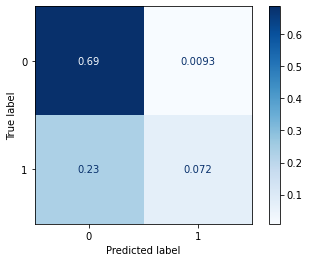

In [43]:
display(Markdown('__Logistic Regression__'))
metrics_report(lr_gscv.best_estimator_, [X_test, y_test])

__Decision Tree__

{'accuracy': 0.7822706065318819,
 'confusion_matrix': {'tn': 410, 'fp': 37, 'fn': 103, 'tp': 93},
 'recall': 0.4744897959183674,
 'precision': 0.7153846153846154,
 'f1_score': 0.5705521472392638,
 'matthews_corrcoef': 0.4489753201149668}

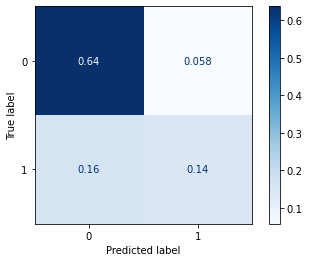

In [44]:
display(Markdown('__Decision Tree__'))
metrics_report(dt_gscv.best_estimator_, [X_test, y_test])

__Random Forest__

{'accuracy': 0.7993779160186625,
 'confusion_matrix': {'tn': 411, 'fp': 36, 'fn': 93, 'tp': 103},
 'recall': 0.5255102040816326,
 'precision': 0.7410071942446043,
 'f1_score': 0.6149253731343284,
 'matthews_corrcoef': 0.4976145529118351}

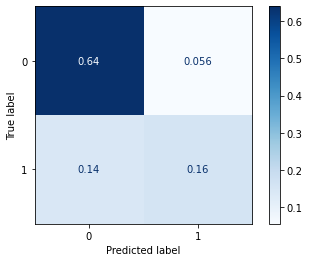

In [45]:
display(Markdown('__Random Forest__'))
metrics_report(rf_gscv.best_estimator_, [X_test, y_test])

<br>

## Conclusions
***
[back](#Table-of-Contents)

In [46]:
print(f'Selected model:\n\t{rf_gscv.best_estimator_}\n\nScore:\t{rf_test_accuracy}')

Selected model:
	RandomForestClassifier(criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.001, min_samples_leaf=3,
                       random_state=12345)

Score:	0.7993779160186625


'Random Forest' model shows the best metrics, which solidifies our choice of it.

The results are less than optimal, and the accuracy is still pretty low.  
Our model's performance should be further improved by applying trying different combinations of hyperparameters, and apply different techniques of data preprocessing (normalization, feature engineering etc..).  
Also, other (more modern) model types can be considered,  
and GPU-acceleration utilized to facilitate rapid development and experimentation.

<div class="alert alert-success">
<b>Reviewer's comment</b>
  
Ok, great, you compared your models to a simple constant baseline. It's important to have a baseline to make sure that the models did learn something non-trivial. As you noted, due to class imbalance, a constant model always predicting the majority class is a better baseline than a constant model. Due to the classes having 70:30 proportion, such a model gets 0.7 accuracy for free. For this reason, accuracy is a poor choice of metric for highly imblanced data. The other metrics and ways to mitigate the imbalance problem will be explored further in the next project.
  
</div>